In [1]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
import warnings
warnings.filterwarnings('ignore')

print("✅ Toutes les bibliothèques importées avec succès!")

2025-11-17 16:13:02.673513: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-17 16:13:05.295745: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-17 16:13:14.362046: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


✅ Toutes les bibliothèques importées avec succès!


In [2]:
# Chemins des fichiers
path_energy = '/home/djeddi/Desktop/Projet_Energie_Groupe5/Donnees/energy_efficiency_data.csv'
path_cleaned = '/home/djeddi/Desktop/Projet_Energie_Groupe5/Donnees/cleaned_building_data.csv'

print("📁 CHARGEMENT DES DATASETS...")
print("="*50)

# Chargement du dataset principal
try:
    data_energy = pd.read_csv(path_energy)
    print(f"✅ energy_efficiency_data.csv chargé - Shape: {data_energy.shape}")
except FileNotFoundError:
    print("❌ energy_efficiency_data.csv non trouvé")
    data_energy = None

# Chargement du dataset nettoyé
try:
    data_cleaned = pd.read_csv(path_cleaned)
    print(f"✅ cleaned_building_data.csv chargé - Shape: {data_cleaned.shape}")
except FileNotFoundError:
    print("❌ cleaned_building_data.csv non trouvé")
    data_cleaned = None

# Décision sur quel dataset utiliser
if data_cleaned is not None:
    data = data_cleaned
    print("\n🎯 UTILISATION DU DATASET NETTOYÉ (cleaned_building_data.csv)")
else:
    data = data_energy
    print("\n🎯 UTILISATION DU DATASET ORIGINAL (energy_efficiency_data.csv)")

print(f"📊 Dataset final - Shape: {data.shape}")
print(f"🔍 Colonnes: {data.columns.tolist()}")

📁 CHARGEMENT DES DATASETS...
✅ energy_efficiency_data.csv chargé - Shape: (768, 10)
✅ cleaned_building_data.csv chargé - Shape: (768, 10)

🎯 UTILISATION DU DATASET NETTOYÉ (cleaned_building_data.csv)
📊 Dataset final - Shape: (768, 10)
🔍 Colonnes: ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load']


In [3]:
print("🔍 EXPLORATION DÉTAILLÉE DU DATASET")
print("="*50)

# Affichage des informations de base
print("📋 Informations générales:")
print(data.info())
print(f"\n🎯 Target variables disponibles: {[col for col in data.columns if 'load' in col.lower() or 'consumption' in col.lower()]}")

# Vérification des valeurs manquantes
print(f"\n🔍 VALEURS MANQUANTES:")
missing_data = data.isnull().sum()
print(missing_data[missing_data > 0])

if missing_data.sum() == 0:
    print("✅ Aucune valeur manquante détectée!")
else:
    print(f"⚠️  {missing_data.sum()} valeurs manquantes au total")

# Affichage des premières lignes
print("\n📖 PREMIÈRES LIGNES:")
data.head(10)

🔍 EXPLORATION DÉTAILLÉE DU DATASET
📋 Informations générales:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB
None

🎯 Target variables disponibles: ['Heating_Load', 'Cooling_Load']

🔍 VALEURS MANQUANTES:
Series([], dtype:

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
5,0.90,563.5,318.5,122.50,7.0,3,0.0,0,21.46,25.38
6,0.90,563.5,318.5,122.50,7.0,4,0.0,0,20.71,25.16
7,0.90,563.5,318.5,122.50,7.0,5,0.0,0,19.68,29.60
8,0.86,588.0,294.0,147.00,7.0,2,0.0,0,19.50,27.30
9,0.86,588.0,294.0,147.00,7.0,3,0.0,0,19.95,21.97


🎯 VARIABLES CIBLES IDENTIFIÉES: ['Heating_Load', 'Cooling_Load']
🔥 Heating target: Heating_Load
❄️ Cooling target: Cooling_Load

📦 DIMENSIONS FINALES:
Features (X): (768, 8)
Target Heating: (768,)
Target Cooling: (768,)


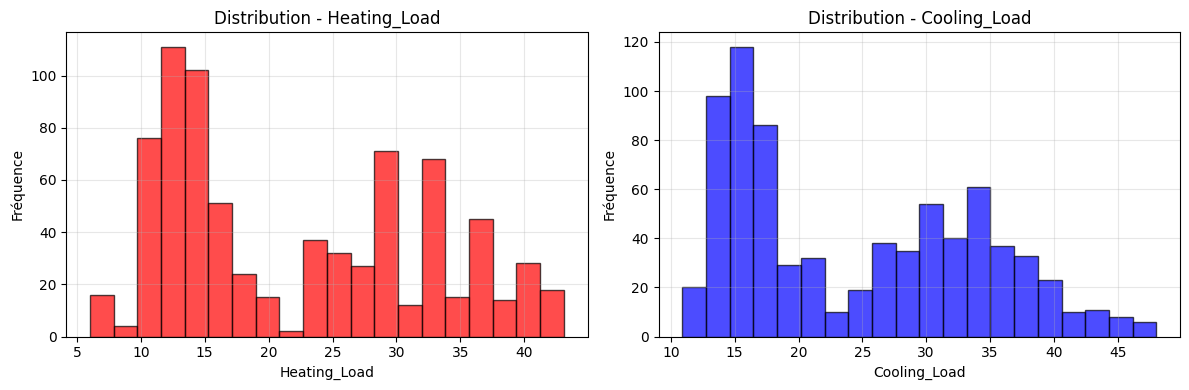

In [4]:
# Identification automatique des variables cibles
target_columns = []
possible_targets = ['heating', 'cooling', 'load', 'consumption', 'energy']

for col in data.columns:
    if any(keyword in col.lower() for keyword in possible_targets):
        target_columns.append(col)

print(f"🎯 VARIABLES CIBLES IDENTIFIÉES: {target_columns}")

if len(target_columns) >= 2:
    y_heating = data[target_columns[0]]
    y_cooling = data[target_columns[1]]
    print(f"🔥 Heating target: {target_columns[0]}")
    print(f"❄️ Cooling target: {target_columns[1]}")
else:
    # Fallback sur les noms standards
    if 'Heating_Load' in data.columns and 'Cooling_Load' in data.columns:
        y_heating = data['Heating_Load']
        y_cooling = data['Cooling_Load']
        target_columns = ['Heating_Load', 'Cooling_Load']
        print("✅ Utilisation des targets standard: Heating_Load, Cooling_Load")
    else:
        print("❌ Impossible d'identifier les variables cibles automatiquement")
        # Utiliser les deux premières colonnes numériques comme fallback
        numeric_cols = data.select_dtypes(include=[np.number]).columns
        y_heating = data[numeric_cols[-2]]
        y_cooling = data[numeric_cols[-1]]
        target_columns = [numeric_cols[-2], numeric_cols[-1]]
        print(f"🔄 Utilisation des colonnes: {target_columns}")

# Features (toutes les colonnes sauf les targets)
X = data.drop(target_columns, axis=1)

print(f"\n📦 DIMENSIONS FINALES:")
print(f"Features (X): {X.shape}")
print(f"Target Heating: {y_heating.shape}")
print(f"Target Cooling: {y_cooling.shape}")

# Visualisation des distributions des targets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(y_heating, bins=20, alpha=0.7, color='red', edgecolor='black')
ax1.set_xlabel(target_columns[0])
ax1.set_ylabel('Fréquence')
ax1.set_title(f'Distribution - {target_columns[0]}')
ax1.grid(True, alpha=0.3)

ax2.hist(y_cooling, bins=20, alpha=0.7, color='blue', edgecolor='black')
ax2.set_xlabel(target_columns[1])
ax2.set_ylabel('Fréquence')
ax2.set_title(f'Distribution - {target_columns[1]}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
print("🛠️ PRÉPARATION DES DONNÉES POUR LA MODÉLISATION")
print("="*50)

# Split des données
X_train, X_test, y_heating_train, y_heating_test = train_test_split(
    X, y_heating, test_size=0.3, random_state=42, shuffle=True
)

X_train_cool, X_test_cool, y_cooling_train, y_cooling_test = train_test_split(
    X, y_cooling, test_size=0.3, random_state=42, shuffle=True
)

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_cool_scaled = scaler.fit_transform(X_train_cool)
X_test_cool_scaled = scaler.transform(X_test_cool)

print(f"✅ DONNÉES PRÉPARÉES:")
print(f"Train set - Heating: {X_train_scaled.shape}")
print(f"Test set - Heating: {X_test_scaled.shape}")
print(f"Train set - Cooling: {X_train_cool_scaled.shape}")
print(f"Test set - Cooling: {X_test_cool_scaled.shape}")

print(f"\n📊 STATISTIQUES DES TARGETS:")
print(f"Heating - Train: {y_heating_train.mean():.2f} ± {y_heating_train.std():.2f}")
print(f"Heating - Test:  {y_heating_test.mean():.2f} ± {y_heating_test.std():.2f}")
print(f"Cooling - Train: {y_cooling_train.mean():.2f} ± {y_cooling_train.std():.2f}")
print(f"Cooling - Test:  {y_cooling_test.mean():.2f} ± {y_cooling_test.std():.2f}")

🛠️ PRÉPARATION DES DONNÉES POUR LA MODÉLISATION
✅ DONNÉES PRÉPARÉES:
Train set - Heating: (537, 8)
Test set - Heating: (231, 8)
Train set - Cooling: (537, 8)
Test set - Cooling: (231, 8)

📊 STATISTIQUES DES TARGETS:
Heating - Train: 22.05 ± 10.09
Heating - Test:  22.90 ± 10.09
Cooling - Train: 24.29 ± 9.51
Cooling - Test:  25.29 ± 9.51


In [6]:
print("🎯 IMPLÉMENTATION KNN REGRESSOR")
print("="*50)

# Configuration de la recherche d'hyperparamètres
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

print("🔥 ENTRAÎNEMENT KNN - HEATING LOAD...")
knn_heating = GridSearchCV(
    KNeighborsRegressor(),
    param_grid_knn,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0
)
knn_heating.fit(X_train_scaled, y_heating_train)

print("❄️ ENTRAÎNEMENT KNN - COOLING LOAD...")
knn_cooling = GridSearchCV(
    KNeighborsRegressor(),
    param_grid_knn,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0
)
knn_cooling.fit(X_train_cool_scaled, y_cooling_train)

print(f"✅ MEILLEURS PARAMÈTRES KNN:")
print(f"Heating: {knn_heating.best_params_}")
print(f"Cooling: {knn_cooling.best_params_}")

# Évaluation KNN
y_pred_knn_heating = knn_heating.predict(X_test_scaled)
y_pred_knn_cooling = knn_cooling.predict(X_test_cool_scaled)

mse_knn_heating = mean_squared_error(y_heating_test, y_pred_knn_heating)
mae_knn_heating = mean_absolute_error(y_heating_test, y_pred_knn_heating)
r2_knn_heating = r2_score(y_heating_test, y_pred_knn_heating)

mse_knn_cooling = mean_squared_error(y_cooling_test, y_pred_knn_cooling)
mae_knn_cooling = mean_absolute_error(y_cooling_test, y_pred_knn_cooling)
r2_knn_cooling = r2_score(y_cooling_test, y_pred_knn_cooling)

print(f"\n📊 PERFORMANCE KNN:")
print(f"Heating - MSE: {mse_knn_heating:.4f}, MAE: {mae_knn_heating:.4f}, R²: {r2_knn_heating:.4f}")
print(f"Cooling - MSE: {mse_knn_cooling:.4f}, MAE: {mae_knn_cooling:.4f}, R²: {r2_knn_cooling:.4f}")

🎯 IMPLÉMENTATION KNN REGRESSOR
🔥 ENTRAÎNEMENT KNN - HEATING LOAD...
❄️ ENTRAÎNEMENT KNN - COOLING LOAD...
✅ MEILLEURS PARAMÈTRES KNN:
Heating: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Cooling: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

📊 PERFORMANCE KNN:
Heating - MSE: 1.0986, MAE: 0.7258, R²: 0.9892
Cooling - MSE: 2.7003, MAE: 1.1392, R²: 0.9700


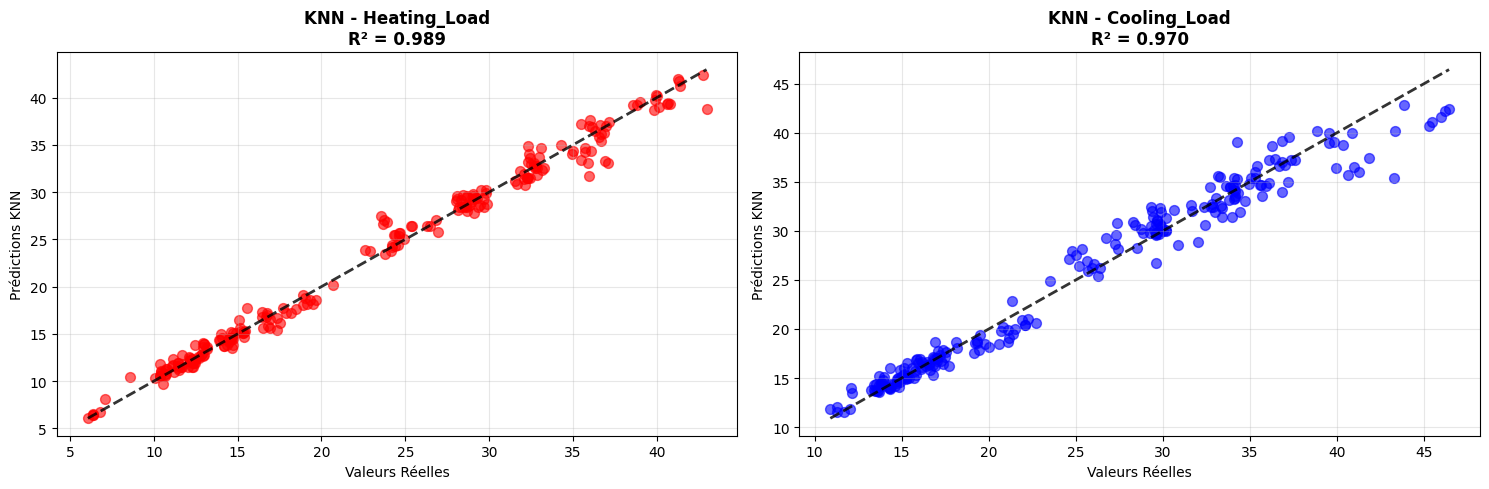

In [7]:
# Visualisation KNN
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Heating Load
ax1.scatter(y_heating_test, y_pred_knn_heating, alpha=0.6, color='red', s=50)
ax1.plot([y_heating_test.min(), y_heating_test.max()], 
        [y_heating_test.min(), y_heating_test.max()], 'k--', lw=2, alpha=0.8)
ax1.set_xlabel('Valeurs Réelles')
ax1.set_ylabel('Prédictions KNN')
ax1.set_title(f'KNN - {target_columns[0]}\nR² = {r2_knn_heating:.3f}', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Cooling Load
ax2.scatter(y_cooling_test, y_pred_knn_cooling, alpha=0.6, color='blue', s=50)
ax2.plot([y_cooling_test.min(), y_cooling_test.max()], 
        [y_cooling_test.min(), y_cooling_test.max()], 'k--', lw=2, alpha=0.8)
ax2.set_xlabel('Valeurs Réelles')
ax2.set_ylabel('Prédictions KNN')
ax2.set_title(f'KNN - {target_columns[1]}\nR² = {r2_knn_cooling:.3f}', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
print("🧠 IMPLÉMENTATION RÉSEAUX DE NEURONES (ANN)")
print("="*50)

def create_ann_model(input_dim, name_suffix=""):
    """Crée un modèle de réseau de neurones"""
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,), name=f'dense1_{name_suffix}'),
        Dropout(0.3, name=f'dropout1_{name_suffix}'),
        Dense(32, activation='relu', name=f'dense2_{name_suffix}'),
        Dropout(0.2, name=f'dropout2_{name_suffix}'),
        Dense(16, activation='relu', name=f'dense3_{name_suffix}'),
        Dense(1, name=f'output_{name_suffix}')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

# Création des modèles
print("🔥 CRÉATION ANN - HEATING LOAD...")
model_heating = create_ann_model(X_train_scaled.shape[1], "heating")
print("❄️ CRÉATION ANN - COOLING LOAD...")
model_cooling = create_ann_model(X_train_cool_scaled.shape[1], "cooling")

print("📋 ARCHITECTURE DES MODÈLES ANN:")
print(f"Heating model - {model_heating.count_params()} paramètres")
print(f"Cooling model - {model_cooling.count_params()} paramètres")

# Callback pour early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=0
)

print("\n🚀 ENTRAÎNEMENT DES RÉSEAUX DE NEURONES...")
print("🔥 ANN - HEATING LOAD...")
history_heating = model_heating.fit(
    X_train_scaled, y_heating_train,
    validation_split=0.2,
    epochs=150,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

print("❄️ ANN - COOLING LOAD...")
history_cooling = model_cooling.fit(
    X_train_cool_scaled, y_cooling_train,
    validation_split=0.2,
    epochs=150,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

print("✅ ENTRAÎNEMENT ANN TERMINÉ!")

🧠 IMPLÉMENTATION RÉSEAUX DE NEURONES (ANN)
🔥 CRÉATION ANN - HEATING LOAD...


2025-11-17 16:14:24.217920: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


❄️ CRÉATION ANN - COOLING LOAD...
📋 ARCHITECTURE DES MODÈLES ANN:
Heating model - 3201 paramètres
Cooling model - 3201 paramètres

🚀 ENTRAÎNEMENT DES RÉSEAUX DE NEURONES...
🔥 ANN - HEATING LOAD...
Epoch 1/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 581.6107 - mae: 21.8396 - val_loss: 476.1206 - val_mae: 19.9424
Epoch 2/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 520.8973 - mae: 20.3822 - val_loss: 389.7310 - val_mae: 17.6561
Epoch 3/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 369.4381 - mae: 16.2747 - val_loss: 182.2622 - val_mae: 10.8115
Epoch 4/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 131.1642 - mae: 8.3588 - val_loss: 34.4234 - val_mae: 3.8792
Epoch 5/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 48.1225 - mae: 4.8746 - val_loss: 27.8282 - val_mae: 3.4844
Epoch 6/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 42.0443 - mae: 4.7936 - val_loss: 22.7223 - val_mae: 3.1916
Epoch 7/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 38.6561 - 

In [9]:
# Prédictions ANN
y_pred_ann_heating = model_heating.predict(X_test_scaled).flatten()
y_pred_ann_cooling = model_cooling.predict(X_test_cool_scaled).flatten()

# Métriques ANN
mse_ann_heating = mean_squared_error(y_heating_test, y_pred_ann_heating)
mae_ann_heating = mean_absolute_error(y_heating_test, y_pred_ann_heating)
r2_ann_heating = r2_score(y_heating_test, y_pred_ann_heating)

mse_ann_cooling = mean_squared_error(y_cooling_test, y_pred_ann_cooling)
mae_ann_cooling = mean_absolute_error(y_cooling_test, y_pred_ann_cooling)
r2_ann_cooling = r2_score(y_cooling_test, y_pred_ann_cooling)

print("📊 PERFORMANCE RÉSEAUX DE NEURONES:")
print(f"Heating - MSE: {mse_ann_heating:.4f}, MAE: {mae_ann_heating:.4f}, R²: {r2_ann_heating:.4f}")
print(f"Cooling - MSE: {mse_ann_cooling:.4f}, MAE: {mae_ann_cooling:.4f}, R²: {r2_ann_cooling:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
📊 PERFORMANCE RÉSEAUX DE NEURONES:
Heating - MSE: 6.7695, MAE: 1.7846, R²: 0.9332
Cooling - MSE: 645.1034, MAE: 23.6770, R²: -6.1568


📈 VISUALISATION COMPLÈTE DES RÉSULTATS


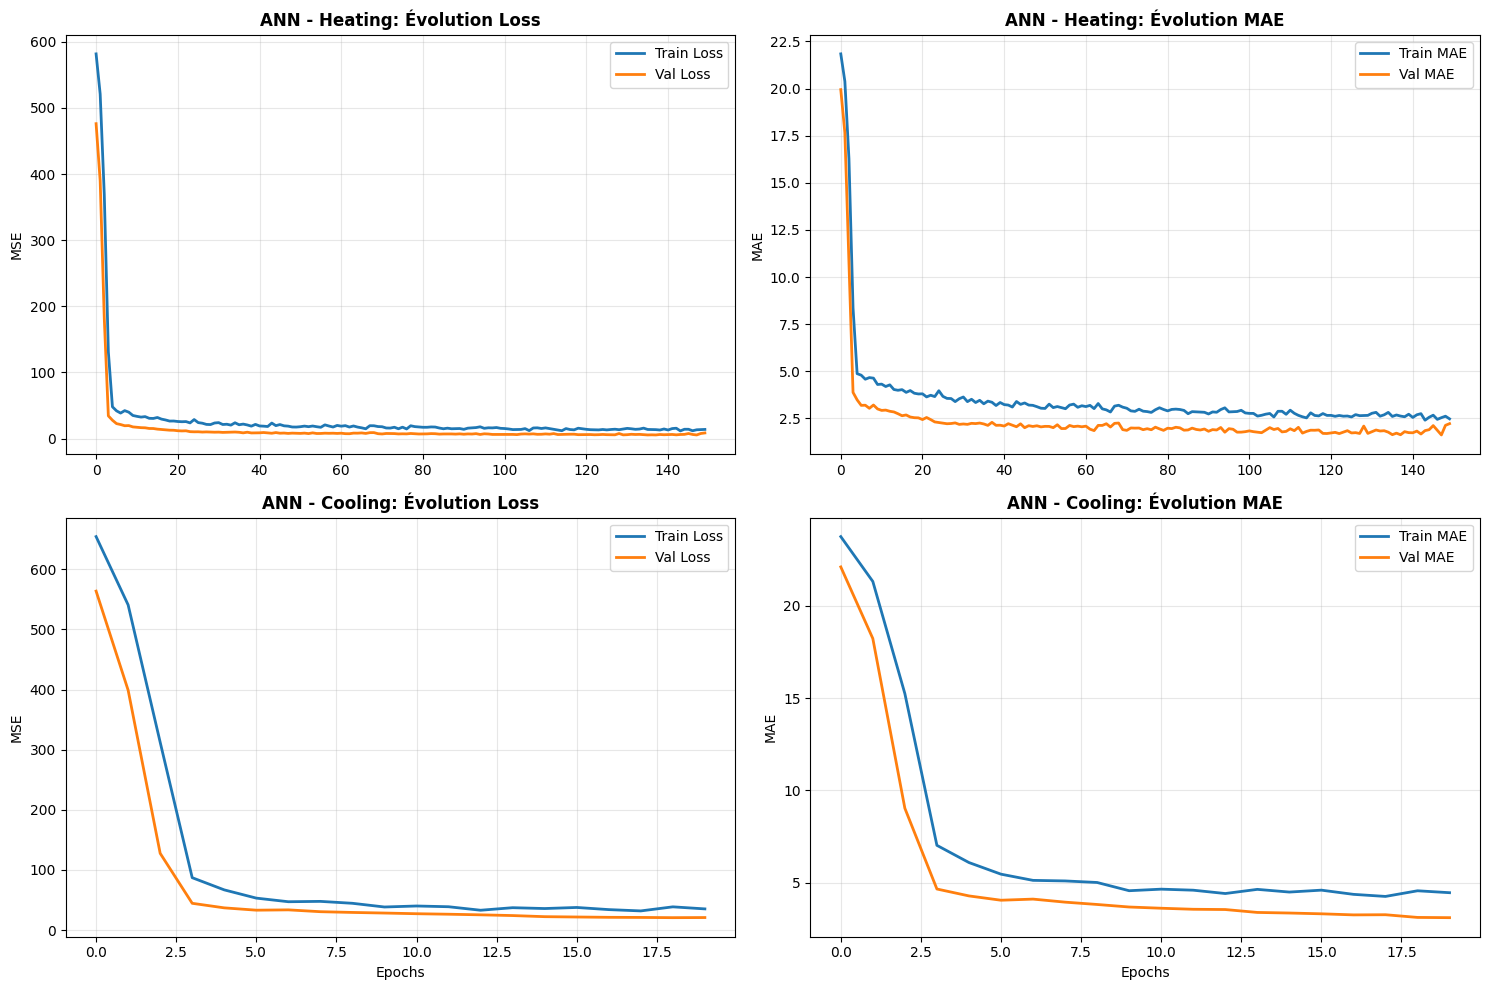

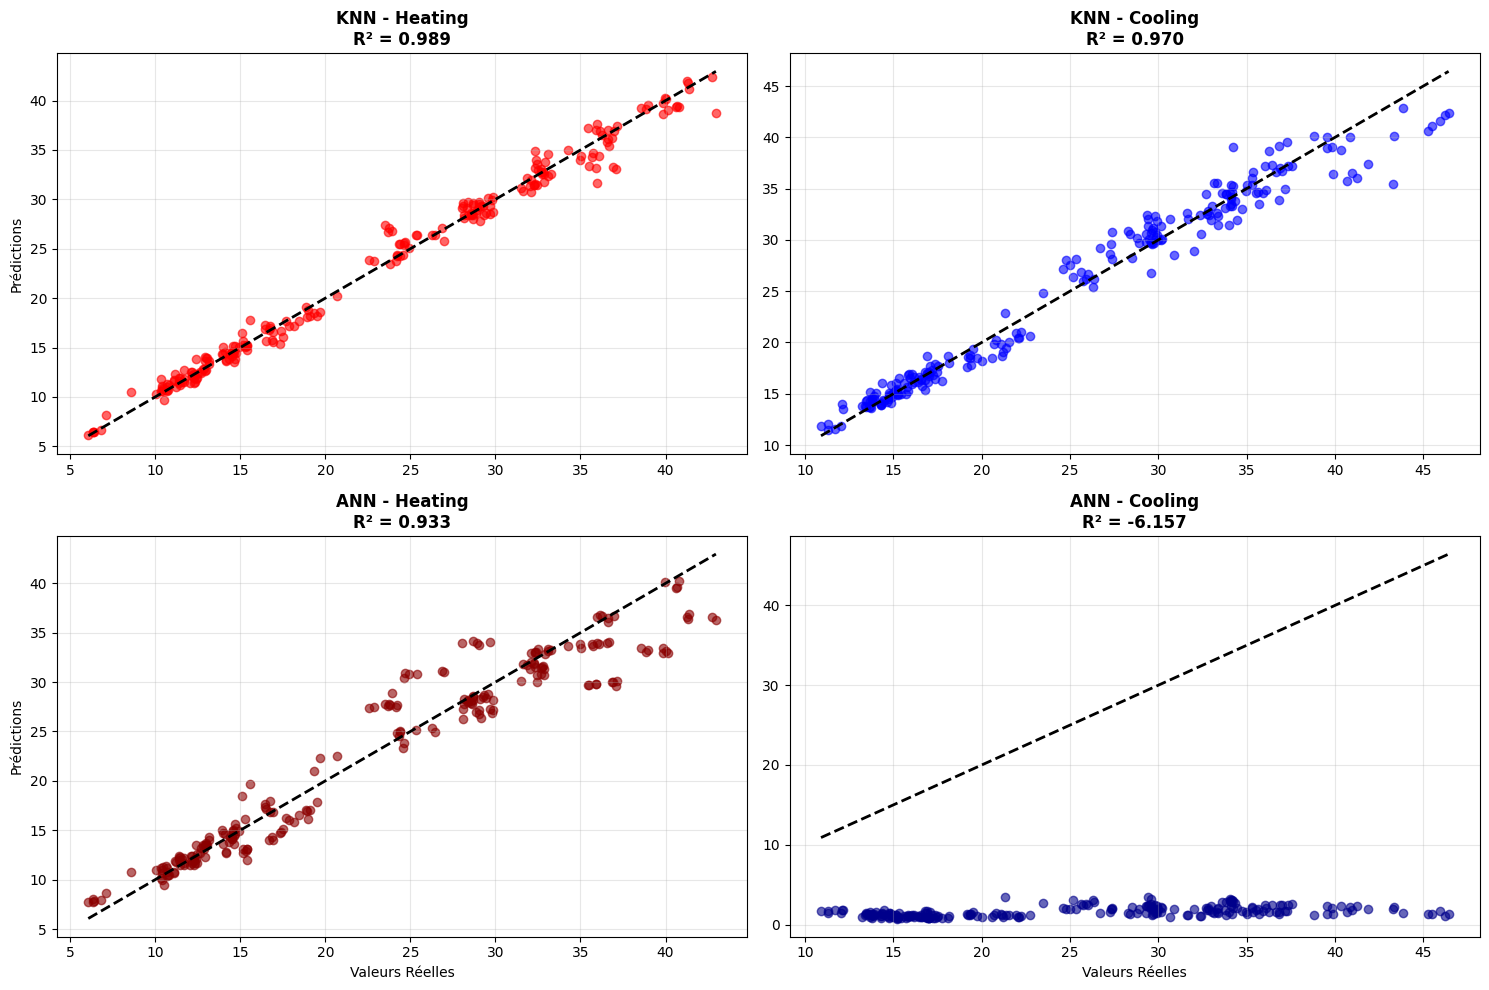

In [10]:
print("📈 VISUALISATION COMPLÈTE DES RÉSULTATS")
print("="*50)

# 1. Courbes d'apprentissage ANN
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Heating Loss
ax1.plot(history_heating.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(history_heating.history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_title('ANN - Heating: Évolution Loss', fontweight='bold')
ax1.set_ylabel('MSE')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Heating MAE
ax2.plot(history_heating.history['mae'], label='Train MAE', linewidth=2)
ax2.plot(history_heating.history['val_mae'], label='Val MAE', linewidth=2)
ax2.set_title('ANN - Heating: Évolution MAE', fontweight='bold')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Cooling Loss
ax3.plot(history_cooling.history['loss'], label='Train Loss', linewidth=2)
ax3.plot(history_cooling.history['val_loss'], label='Val Loss', linewidth=2)
ax3.set_title('ANN - Cooling: Évolution Loss', fontweight='bold')
ax3.set_ylabel('MSE')
ax3.set_xlabel('Epochs')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Cooling MAE
ax4.plot(history_cooling.history['mae'], label='Train MAE', linewidth=2)
ax4.plot(history_cooling.history['val_mae'], label='Val MAE', linewidth=2)
ax4.set_title('ANN - Cooling: Évolution MAE', fontweight='bold')
ax4.set_ylabel('MAE')
ax4.set_xlabel('Epochs')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Comparaison prédictions vs réalité
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# KNN Predictions
ax1.scatter(y_heating_test, y_pred_knn_heating, alpha=0.6, color='red')
ax1.plot([y_heating_test.min(), y_heating_test.max()], 
         [y_heating_test.min(), y_heating_test.max()], 'k--', lw=2)
ax1.set_title(f'KNN - Heating\nR² = {r2_knn_heating:.3f}', fontweight='bold')
ax1.set_ylabel('Prédictions')
ax1.grid(True, alpha=0.3)

ax2.scatter(y_cooling_test, y_pred_knn_cooling, alpha=0.6, color='blue')
ax2.plot([y_cooling_test.min(), y_cooling_test.max()], 
         [y_cooling_test.min(), y_cooling_test.max()], 'k--', lw=2)
ax2.set_title(f'KNN - Cooling\nR² = {r2_knn_cooling:.3f}', fontweight='bold')
ax2.grid(True, alpha=0.3)

# ANN Predictions
ax3.scatter(y_heating_test, y_pred_ann_heating, alpha=0.6, color='darkred')
ax3.plot([y_heating_test.min(), y_heating_test.max()], 
         [y_heating_test.min(), y_heating_test.max()], 'k--', lw=2)
ax3.set_title(f'ANN - Heating\nR² = {r2_ann_heating:.3f}', fontweight='bold')
ax3.set_xlabel('Valeurs Réelles')
ax3.set_ylabel('Prédictions')
ax3.grid(True, alpha=0.3)

ax4.scatter(y_cooling_test, y_pred_ann_cooling, alpha=0.6, color='darkblue')
ax4.plot([y_cooling_test.min(), y_cooling_test.max()], 
         [y_cooling_test.min(), y_cooling_test.max()], 'k--', lw=2)
ax4.set_title(f'ANN - Cooling\nR² = {r2_ann_cooling:.3f}', fontweight='bold')
ax4.set_xlabel('Valeurs Réelles')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

🏆 ANALYSE COMPARATIVE FINALE
📊 TABLEAU COMPARATIF DÉTAILLÉ:
          Modèle       MSE      MAE      R²  \
0  KNN - Heating    1.0986   0.7258  0.9892   
1  KNN - Cooling    2.7003   1.1392  0.9700   
2  ANN - Heating    6.7695   1.7846  0.9332   
3  ANN - Cooling  645.1034  23.6770 -6.1568   

                                Meilleurs_Paramètres  
0  {'metric': 'manhattan', 'n_neighbors': 3, 'wei...  
1  {'metric': 'manhattan', 'n_neighbors': 5, 'wei...  
2                               3 couches (64-32-16)  
3                               3 couches (64-32-16)  


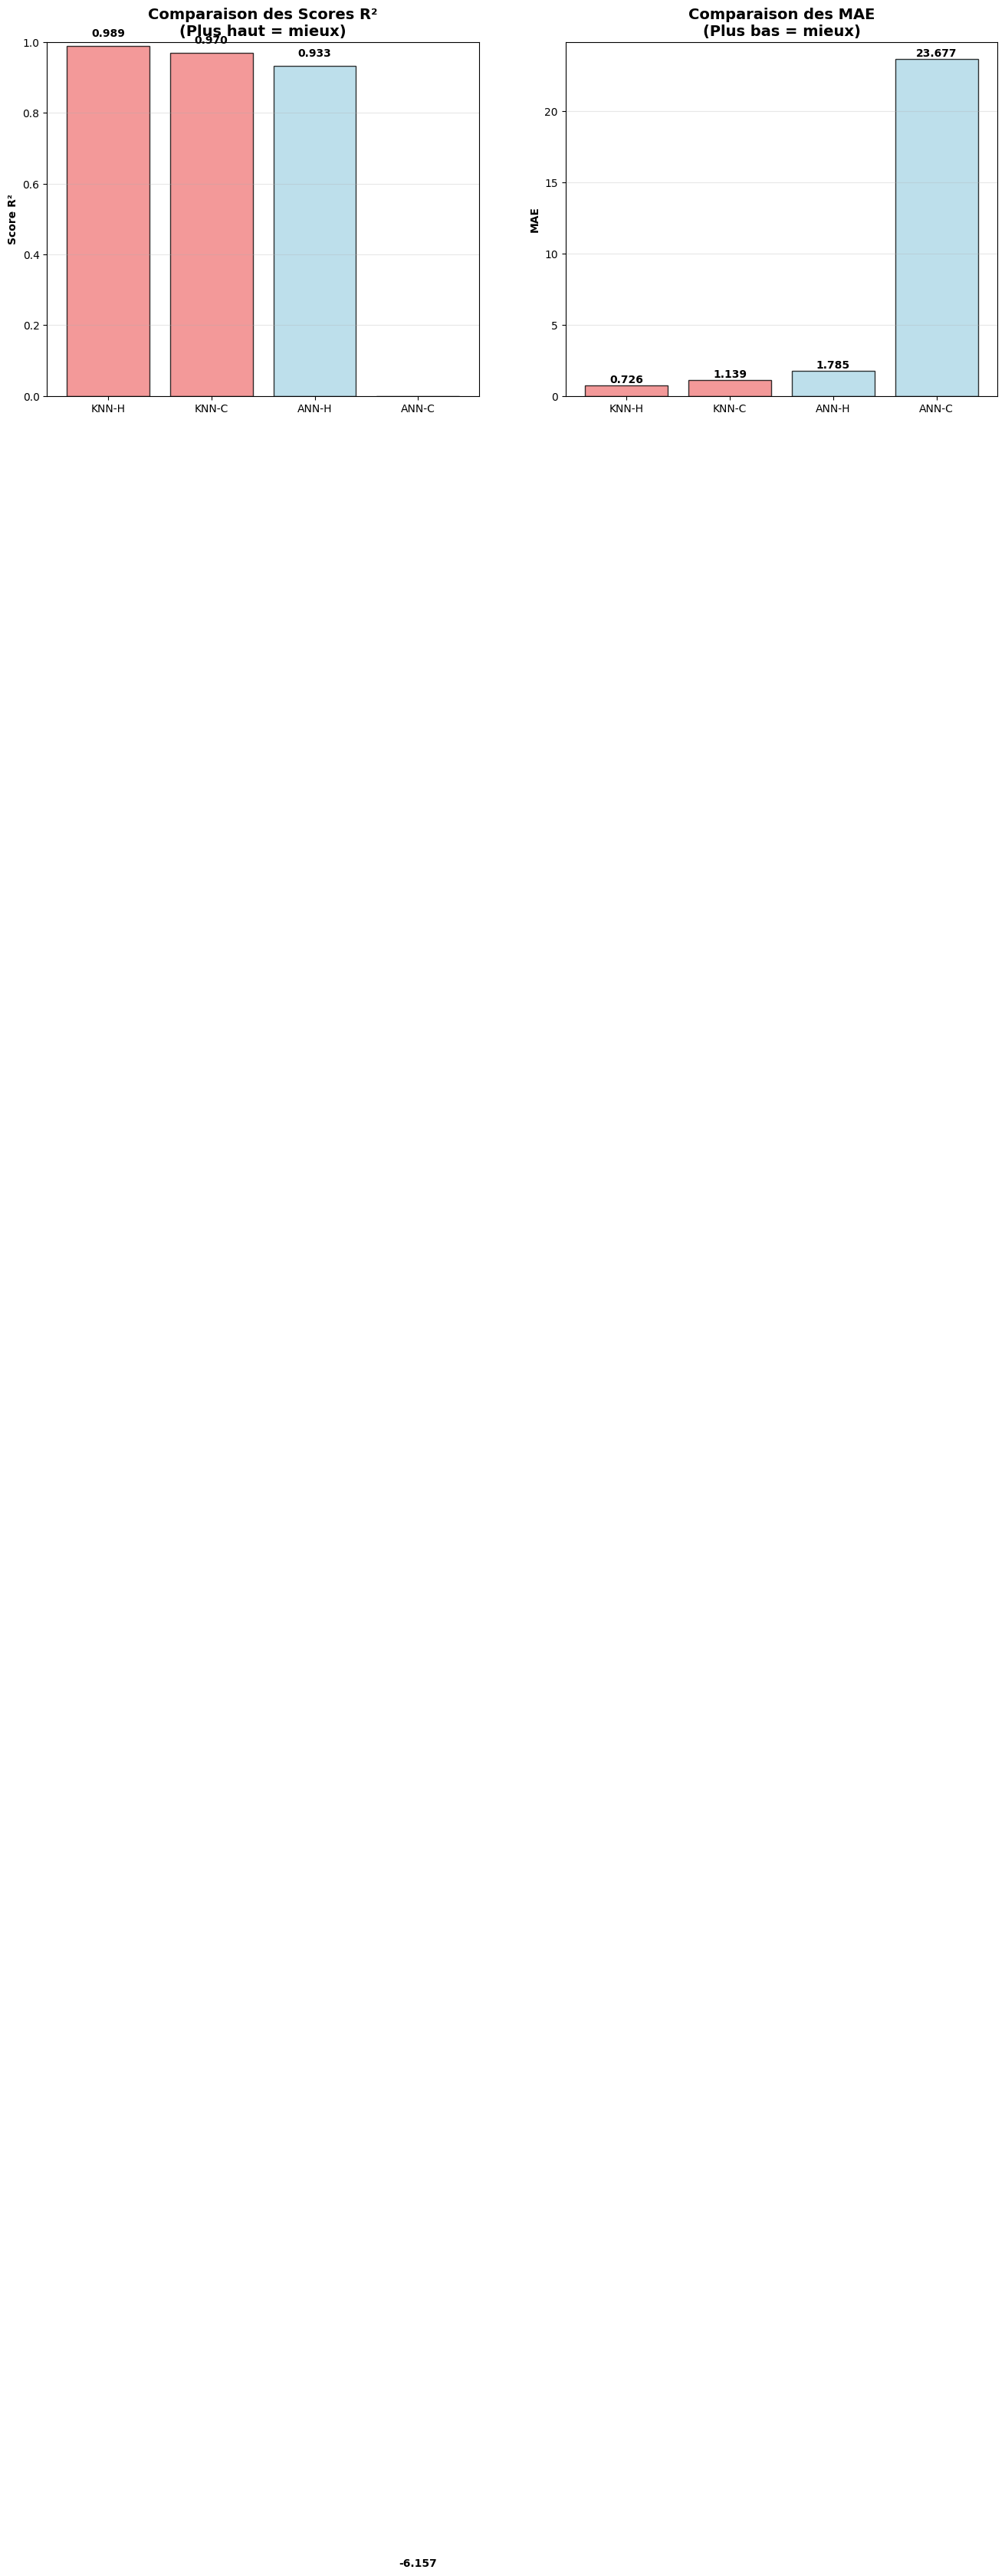

In [11]:
print("🏆 ANALYSE COMPARATIVE FINALE")
print("="*50)

# Tableau comparatif
results_comparison = pd.DataFrame({
    'Modèle': ['KNN - Heating', 'KNN - Cooling', 'ANN - Heating', 'ANN - Cooling'],
    'MSE': [mse_knn_heating, mse_knn_cooling, mse_ann_heating, mse_ann_cooling],
    'MAE': [mae_knn_heating, mae_knn_cooling, mae_ann_heating, mae_ann_cooling],
    'R²': [r2_knn_heating, r2_knn_cooling, r2_ann_heating, r2_ann_cooling],
    'Meilleurs_Paramètres': [
        str(knn_heating.best_params_),
        str(knn_cooling.best_params_),
        '3 couches (64-32-16)',
        '3 couches (64-32-16)'
    ]
})

print("📊 TABLEAU COMPARATIF DÉTAILLÉ:")
print(results_comparison.round(4))

# Visualisation comparative
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Comparaison R²
models_short = ['KNN-H', 'KNN-C', 'ANN-H', 'ANN-C']
r2_values = [r2_knn_heating, r2_knn_cooling, r2_ann_heating, r2_ann_cooling]
colors = ['lightcoral', 'lightcoral', 'lightblue', 'lightblue']

bars1 = ax1.bar(models_short, r2_values, color=colors, edgecolor='black', alpha=0.8)
ax1.set_ylabel('Score R²', fontweight='bold')
ax1.set_title('Comparaison des Scores R²\n(Plus haut = mieux)', fontweight='bold', fontsize=14)
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars1, r2_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Comparaison MAE
mae_values = [mae_knn_heating, mae_knn_cooling, mae_ann_heating, mae_ann_cooling]

bars2 = ax2.bar(models_short, mae_values, color=colors, edgecolor='black', alpha=0.8)
ax2.set_ylabel('MAE', fontweight='bold')
ax2.set_title('Comparaison des MAE\n(Plus bas = mieux)', fontweight='bold', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars2, mae_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [17]:
print("💾 SAUVEGARDE DE TOUS LES RÉSULTATS ET FIGURES")
print("="*50)

# Création de tous les dossiers nécessaires
os.makedirs('resultats_travail/Modeles', exist_ok=True)
os.makedirs('resultats_travail/Resultats_Membre3', exist_ok=True)
os.makedirs('resultats_travail/Figures', exist_ok=True)

import joblib

# Sauvegarde des modèles KNN
joblib.dump(knn_heating, 'resultats_travail/Modeles/knn_heating_model.pkl')
joblib.dump(knn_cooling, 'resultats_travail/Modeles/knn_cooling_model.pkl')

# Sauvegarde des modèles ANN
model_heating.save('resultats_travail/Modeles/ann_heating_model.keras')
model_cooling.save('resultats_travail/Modeles/ann_cooling_model.keras')

# Sauvegarde des résultats
results_comparison.to_csv('resultats_travail/Resultats_Membre3/comparaison_modeles.csv', index=False)

# Sauvegarde des métriques d'entraînement
print("📊 Préparation des métriques d'entraînement...")
min_length = min(len(history_heating.history['loss']), len(history_cooling.history['loss']))

training_metrics = pd.DataFrame({
    'epoch': range(1, min_length + 1),
    'heating_loss': history_heating.history['loss'][:min_length],
    'heating_val_loss': history_heating.history['val_loss'][:min_length],
    'heating_mae': history_heating.history['mae'][:min_length],
    'heating_val_mae': history_heating.history['val_mae'][:min_length],
    'cooling_loss': history_cooling.history['loss'][:min_length],
    'cooling_val_loss': history_cooling.history['val_loss'][:min_length],
    'cooling_mae': history_cooling.history['mae'][:min_length],
    'cooling_val_mae': history_cooling.history['val_mae'][:min_length]
})
training_metrics.to_csv('resultats_travail/Resultats_Membre3/training_metrics.csv', index=False)

# Sauvegarde des meilleures performances
best_metrics = pd.DataFrame({
    'Model': ['KNN_Heating', 'KNN_Cooling', 'ANN_Heating', 'ANN_Cooling'],
    'Best_Params': [
        str(knn_heating.best_params_),
        str(knn_cooling.best_params_),
        f"Epochs: {len(history_heating.history['loss'])}",
        f"Epochs: {len(history_cooling.history['loss'])}"
    ],
    'Final_MSE': [mse_knn_heating, mse_knn_cooling, mse_ann_heating, mse_ann_cooling],
    'Final_MAE': [mae_knn_heating, mae_knn_cooling, mae_ann_heating, mae_ann_cooling],
    'Final_R2': [r2_knn_heating, r2_knn_cooling, r2_ann_heating, r2_ann_cooling]
})
best_metrics.to_csv('resultats_travail/Resultats_Membre3/best_metrics.csv', index=False)

print("✅ Données sauvegardées!")

# ============================================================================
# 🖼️ CRÉATION ET SAUVEGARDE DE TOUTES LES FIGURES
# ============================================================================

print("\n🎨 CRÉATION ET SAUVEGARDE DE TOUTES LES FIGURES")
print("="*50)

# 1. Distribution des variables cibles
print("📊 1. Distribution des variables cibles...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(y_heating, bins=20, alpha=0.7, color='red', edgecolor='black')
ax1.set_xlabel(target_columns[0])
ax1.set_ylabel('Fréquence')
ax1.set_title(f'Distribution - {target_columns[0]}')
ax1.grid(True, alpha=0.3)

ax2.hist(y_cooling, bins=20, alpha=0.7, color='blue', edgecolor='black')
ax2.set_xlabel(target_columns[1])
ax2.set_ylabel('Fréquence')
ax2.set_title(f'Distribution - {target_columns[1]}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resultats_travail/Figures/01_distribution_targets.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. Prédictions KNN
print("📈 2. Prédictions KNN...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(y_heating_test, y_pred_knn_heating, alpha=0.6, color='red', s=50)
ax1.plot([y_heating_test.min(), y_heating_test.max()], 
        [y_heating_test.min(), y_heating_test.max()], 'k--', lw=2, alpha=0.8)
ax1.set_xlabel('Valeurs Réelles')
ax1.set_ylabel('Prédictions KNN')
ax1.set_title(f'KNN - {target_columns[0]}\nR² = {r2_knn_heating:.3f}', fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.scatter(y_cooling_test, y_pred_knn_cooling, alpha=0.6, color='blue', s=50)
ax2.plot([y_cooling_test.min(), y_cooling_test.max()], 
        [y_cooling_test.min(), y_cooling_test.max()], 'k--', lw=2, alpha=0.8)
ax2.set_xlabel('Valeurs Réelles')
ax2.set_ylabel('Prédictions KNN')
ax2.set_title(f'KNN - {target_columns[1]}\nR² = {r2_knn_cooling:.3f}', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resultats_travail/Figures/02_knn_predictions.png', dpi=300, bbox_inches='tight')
plt.close()

# 3. Courbes d'apprentissage ANN
print("🧠 3. Courbes d'apprentissage ANN...")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Heating Loss
ax1.plot(history_heating.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(history_heating.history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_title('ANN - Heating: Évolution Loss', fontweight='bold')
ax1.set_ylabel('MSE')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Heating MAE
ax2.plot(history_heating.history['mae'], label='Train MAE', linewidth=2)
ax2.plot(history_heating.history['val_mae'], label='Val MAE', linewidth=2)
ax2.set_title('ANN - Heating: Évolution MAE', fontweight='bold')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Cooling Loss
ax3.plot(history_cooling.history['loss'], label='Train Loss', linewidth=2)
ax3.plot(history_cooling.history['val_loss'], label='Val Loss', linewidth=2)
ax3.set_title('ANN - Cooling: Évolution Loss', fontweight='bold')
ax3.set_ylabel('MSE')
ax3.set_xlabel('Epochs')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Cooling MAE
ax4.plot(history_cooling.history['mae'], label='Train MAE', linewidth=2)
ax4.plot(history_cooling.history['val_mae'], label='Val MAE', linewidth=2)
ax4.set_title('ANN - Cooling: Évolution MAE', fontweight='bold')
ax4.set_ylabel('MAE')
ax4.set_xlabel('Epochs')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resultats_travail/Figures/03_ann_learning_curves.png', dpi=300, bbox_inches='tight')
plt.close()

# 4. Prédictions ANN
print("📊 4. Prédictions ANN...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(y_heating_test, y_pred_ann_heating, alpha=0.6, color='darkred', s=50)
ax1.plot([y_heating_test.min(), y_heating_test.max()], 
        [y_heating_test.min(), y_heating_test.max()], 'k--', lw=2, alpha=0.8)
ax1.set_xlabel('Valeurs Réelles')
ax1.set_ylabel('Prédictions ANN')
ax1.set_title(f'ANN - {target_columns[0]}\nR² = {r2_ann_heating:.3f}', fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.scatter(y_cooling_test, y_pred_ann_cooling, alpha=0.6, color='darkblue', s=50)
ax2.plot([y_cooling_test.min(), y_cooling_test.max()], 
        [y_cooling_test.min(), y_cooling_test.max()], 'k--', lw=2, alpha=0.8)
ax2.set_xlabel('Valeurs Réelles')
ax2.set_ylabel('Prédictions ANN')
ax2.set_title(f'ANN - {target_columns[1]}\nR² = {r2_ann_cooling:.3f}', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resultats_travail/Figures/04_ann_predictions.png', dpi=300, bbox_inches='tight')
plt.close()

# 5. Comparaison côte à côte KNN vs ANN
print("🆚 5. Comparaison KNN vs ANN...")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# KNN Heating
ax1.scatter(y_heating_test, y_pred_knn_heating, alpha=0.6, color='red')
ax1.plot([y_heating_test.min(), y_heating_test.max()], 
         [y_heating_test.min(), y_heating_test.max()], 'k--', lw=2)
ax1.set_title(f'KNN - Heating\nR² = {r2_knn_heating:.3f}', fontweight='bold')
ax1.set_ylabel('Prédictions')
ax1.grid(True, alpha=0.3)

# KNN Cooling
ax2.scatter(y_cooling_test, y_pred_knn_cooling, alpha=0.6, color='blue')
ax2.plot([y_cooling_test.min(), y_cooling_test.max()], 
         [y_cooling_test.min(), y_cooling_test.max()], 'k--', lw=2)
ax2.set_title(f'KNN - Cooling\nR² = {r2_knn_cooling:.3f}', fontweight='bold')
ax2.grid(True, alpha=0.3)

# ANN Heating
ax3.scatter(y_heating_test, y_pred_ann_heating, alpha=0.6, color='darkred')
ax3.plot([y_heating_test.min(), y_heating_test.max()], 
         [y_heating_test.min(), y_heating_test.max()], 'k--', lw=2)
ax3.set_title(f'ANN - Heating\nR² = {r2_ann_heating:.3f}', fontweight='bold')
ax3.set_xlabel('Valeurs Réelles')
ax3.set_ylabel('Prédictions')
ax3.grid(True, alpha=0.3)

# ANN Cooling
ax4.scatter(y_cooling_test, y_pred_ann_cooling, alpha=0.6, color='darkblue')
ax4.plot([y_cooling_test.min(), y_cooling_test.max()], 
         [y_cooling_test.min(), y_cooling_test.max()], 'k--', lw=2)
ax4.set_title(f'ANN - Cooling\nR² = {r2_ann_cooling:.3f}', fontweight='bold')
ax4.set_xlabel('Valeurs Réelles')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resultats_travail/Figures/05_comparison_predictions.png', dpi=300, bbox_inches='tight')
plt.close()

# 6. Comparaison des performances (R² et MAE)
print("📊 6. Comparaison des performances...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Comparaison R²
models_short = ['KNN-H', 'KNN-C', 'ANN-H', 'ANN-C']
r2_values = [r2_knn_heating, r2_knn_cooling, r2_ann_heating, r2_ann_cooling]
colors = ['lightcoral', 'lightcoral', 'lightblue', 'lightblue']

bars1 = ax1.bar(models_short, r2_values, color=colors, edgecolor='black', alpha=0.8)
ax1.set_ylabel('Score R²', fontweight='bold')
ax1.set_title('Comparaison des Scores R²\n(Plus haut = mieux)', fontweight='bold', fontsize=14)
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars1, r2_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Comparaison MAE
mae_values = [mae_knn_heating, mae_knn_cooling, mae_ann_heating, mae_ann_cooling]

bars2 = ax2.bar(models_short, mae_values, color=colors, edgecolor='black', alpha=0.8)
ax2.set_ylabel('MAE', fontweight='bold')
ax2.set_title('Comparaison des MAE\n(Plus bas = mieux)', fontweight='bold', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars2, mae_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('resultats_travail/Figures/06_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.close()

# 7. Analyse des résidus
print("🔍 7. Analyse des résidus...")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Résidus KNN - Heating
residuals_knn_heating = y_heating_test - y_pred_knn_heating
ax1.scatter(y_pred_knn_heating, residuals_knn_heating, alpha=0.6, color='red')
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.8)
ax1.set_xlabel('Prédictions KNN - Heating')
ax1.set_ylabel('Résidus')
ax1.set_title('Résidus KNN - Heating Load')
ax1.grid(True, alpha=0.3)

# Résidus KNN - Cooling
residuals_knn_cooling = y_cooling_test - y_pred_knn_cooling
ax2.scatter(y_pred_knn_cooling, residuals_knn_cooling, alpha=0.6, color='blue')
ax2.axhline(y=0, color='blue', linestyle='--', alpha=0.8)
ax2.set_xlabel('Prédictions KNN - Cooling')
ax2.set_ylabel('Résidus')
ax2.set_title('Résidus KNN - Cooling Load')
ax2.grid(True, alpha=0.3)

# Résidus ANN - Heating
residuals_ann_heating = y_heating_test - y_pred_ann_heating
ax3.scatter(y_pred_ann_heating, residuals_ann_heating, alpha=0.6, color='darkred')
ax3.axhline(y=0, color='darkred', linestyle='--', alpha=0.8)
ax3.set_xlabel('Prédictions ANN - Heating')
ax3.set_ylabel('Résidus')
ax3.set_title('Résidus ANN - Heating Load')
ax3.grid(True, alpha=0.3)

# Résidus ANN - Cooling
residuals_ann_cooling = y_cooling_test - y_pred_ann_cooling
ax4.scatter(y_pred_ann_cooling, residuals_ann_cooling, alpha=0.6, color='darkblue')
ax4.axhline(y=0, color='darkblue', linestyle='--', alpha=0.8)
ax4.set_xlabel('Prédictions ANN - Cooling')
ax4.set_ylabel('Résidus')
ax4.set_title('Résidus ANN - Cooling Load')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resultats_travail/Figures/07_residuals_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

# 8. Matrice de corrélation des features
print("📈 8. Matrice de corrélation...")
plt.figure(figsize=(10, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Matrice de Corrélation des Features', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('resultats_travail/Figures/08_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

print("✅ TOUTES LES FIGURES SAUVEGARDÉES!")

# ============================================================================
# 📋 RÉSUMÉ FINAL
# ============================================================================

print("\n" + "="*50)
print("📁 RÉSUMÉ DE LA SAUVEGARDE")
print("="*50)

print("🎯 MODÈLES SAUVEGARDÉS:")
print("   • knn_heating_model.pkl")
print("   • knn_cooling_model.pkl") 
print("   • ann_heating_model.keras")
print("   • ann_cooling_model.keras")

print("\n📊 DONNÉES SAUVEGARDÉES:")
print("   • comparaison_modeles.csv")
print("   • training_metrics.csv")
print("   • best_metrics.csv")

print("\n🖼️ FIGURES SAUVEGARDÉES:")
figures_list = [
    "01_distribution_targets.png",
    "02_knn_predictions.png", 
    "03_ann_learning_curves.png",
    "04_ann_predictions.png",
    "05_comparison_predictions.png",
    "06_performance_comparison.png",
    "07_residuals_analysis.png",
    "08_correlation_matrix.png"
]

for fig in figures_list:
    print(f"   • {fig}")

print(f"\n📍 EMPLACEMENT: 'resultats_travail/'")
print("✅ MISSION DU MEMBRE 3 TERMINÉE AVEC SUCCÈS! 🎉")

💾 SAUVEGARDE DE TOUS LES RÉSULTATS ET FIGURES
📊 Préparation des métriques d'entraînement...
✅ Données sauvegardées!

🎨 CRÉATION ET SAUVEGARDE DE TOUTES LES FIGURES
📊 1. Distribution des variables cibles...
📈 2. Prédictions KNN...
🧠 3. Courbes d'apprentissage ANN...
📊 4. Prédictions ANN...
🆚 5. Comparaison KNN vs ANN...
📊 6. Comparaison des performances...
🔍 7. Analyse des résidus...
📈 8. Matrice de corrélation...
✅ TOUTES LES FIGURES SAUVEGARDÉES!

📁 RÉSUMÉ DE LA SAUVEGARDE
🎯 MODÈLES SAUVEGARDÉS:
   • knn_heating_model.pkl
   • knn_cooling_model.pkl
   • ann_heating_model.keras
   • ann_cooling_model.keras

📊 DONNÉES SAUVEGARDÉES:
   • comparaison_modeles.csv
   • training_metrics.csv
   • best_metrics.csv

🖼️ FIGURES SAUVEGARDÉES:
   • 01_distribution_targets.png
   • 02_knn_predictions.png
   • 03_ann_learning_curves.png
   • 04_ann_predictions.png
   • 05_comparison_predictions.png
   • 06_performance_comparison.png
   • 07_residuals_analysis.png
   • 08_correlation_matrix.png

📍 EM

In [15]:
print("🎯 SYNTHÈSE FINALE - MEMBRE 3")
print("="*60)

# Détermination des meilleurs modèles
best_heating = "KNN" if r2_knn_heating > r2_ann_heating else "ANN"
best_cooling = "KNN" if r2_knn_cooling > r2_ann_cooling else "ANN"

best_heating_r2 = max(r2_knn_heating, r2_ann_heating)
best_cooling_r2 = max(r2_knn_cooling, r2_ann_cooling)

print(f"🏆 MEILLEURS MODÈLES IDENTIFIÉS:")
print(f"   🔥 {target_columns[0]}: {best_heating} (R² = {best_heating_r2:.3f})")
print(f"   ❄️  {target_columns[1]}: {best_cooling} (R² = {best_cooling_r2:.3f})")

print(f"\n📈 PERFORMANCE MOYENNE:")
print(f"   KNN: R² moyen = {(r2_knn_heating + r2_knn_cooling)/2:.3f}")
print(f"   ANN: R² moyen = {(r2_ann_heating + r2_ann_cooling)/2:.3f}")

print(f"\n⚡ PARAMÈTRES OPTIMAUX KNN:")
print(f"   Heating: {knn_heating.best_params_}")
print(f"   Cooling: {knn_cooling.best_params_}")

print(f"\n🧠 ARCHITECTURE ANN UTILISÉE:")
print("   3 couches cachées (64-32-16 neurones)")
print("   Dropout: 0.3 (couche 1), 0.2 (couche 2)")
print("   Activation: ReLU, Optimiseur: Adam (lr=0.001)")

print(f"\n📊 CARACTÉRISTIQUES DU DATASET:")
print(f"   Dataset utilisé: {'cleaned_building_data.csv' if data_cleaned is not None else 'energy_efficiency_data.csv'}")
print(f"   Nombre d'échantillons: {data.shape[0]}")
print(f"   Nombre de features: {X.shape[1]}")
print(f"   Variables cibles: {target_columns}")

print("\n" + "="*60)
print("✅ MISSION DU MEMBRE 3 ACCOMPLIE AVEC SUCCÈS! 🎉")
print("📁 Tous les résultats sont sauvegardés et prêts pour l'analyse du Membre 4")

🎯 SYNTHÈSE FINALE - MEMBRE 3
🏆 MEILLEURS MODÈLES IDENTIFIÉS:
   🔥 Heating_Load: KNN (R² = 0.989)
   ❄️  Cooling_Load: KNN (R² = 0.970)

📈 PERFORMANCE MOYENNE:
   KNN: R² moyen = 0.980
   ANN: R² moyen = -2.612

⚡ PARAMÈTRES OPTIMAUX KNN:
   Heating: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
   Cooling: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

🧠 ARCHITECTURE ANN UTILISÉE:
   3 couches cachées (64-32-16 neurones)
   Dropout: 0.3 (couche 1), 0.2 (couche 2)
   Activation: ReLU, Optimiseur: Adam (lr=0.001)

📊 CARACTÉRISTIQUES DU DATASET:
   Dataset utilisé: cleaned_building_data.csv
   Nombre d'échantillons: 768
   Nombre de features: 8
   Variables cibles: ['Heating_Load', 'Cooling_Load']

✅ MISSION DU MEMBRE 3 ACCOMPLIE AVEC SUCCÈS! 🎉
📁 Tous les résultats sont sauvegardés et prêts pour l'analyse du Membre 4
